# E-MOSAIC

引用自[E. R. Q. Fernandes, A. C. P. L. F. de Carvalho and X. Yao, "Ensemble of Classifiers Based on Multiobjective Genetic Sampling for Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 32, no. 6, pp. 1104-1115, 1 June 2020, doi: 10.1109/TKDE.2019.2898861.]


## 数据集的预处理 

## NSGA-II

In [13]:

import numpy as np
from instance_selection.multi_objective.genetic_operator import exponential_distribution, mutate_binary_inversion
import warnings

warnings.filterwarnings("ignore")  # 忽略警告
import array
import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools
from matplotlib.animation import FuncAnimation, PillowWriter


def fitness_function(individual):
    fitness_1 = individual.count(1)
    fitness_2 = 1.0*individual.count(1)/len(individual)
    return round(fitness_1, 4), round(fitness_2, 4)

# 最大化评价目标
creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, mlp=None,
               y_sub_and_pred=None)
toolbox = base.Toolbox()

NDIM = 1000
# 设置参数
lambda_ = 1.0  # 指数分布的参数λ（lambda）在下面的函数中，该值越大越偏向于1
threshold = 1.0  # 阈值（阈值决定了生成0或1）

# 二进制编码
toolbox.register("attr_binary", exponential_distribution, lambda_, threshold)  # 0-1编码
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 适应度函数
toolbox.register("evaluate", fitness_function)

# 单点交叉
toolbox.register("mate", tools.cxOnePoint)

# 二进制突变
toolbox.register("mutate", mutate_binary_inversion)

# NSGA-II选择（非支配排序后）
toolbox.register("select", tools.selNSGA2)
# toolbox.register("select", tools.selNSGA2)

## 种群的迭代

gen	fronts	fronts_0_size	Acc1	Acc2	Acc3	recall_per_class	Gmean	mAUC
1  	25    	1            	    	    	    	                	     	    
2  	22    	1            	    	    	    	                	     	    
3  	22    	1            	    	    	    	                	     	    
4  	21    	1            	    	    	    	                	     	    
5  	21    	1            	    	    	    	                	     	    
6  	18    	1            	    	    	    	                	     	    
7  	16    	1            	    	    	    	                	     	    
8  	17    	1            	    	    	    	                	     	    
9  	18    	2            	    	    	    	                	     	    
10 	16    	2            	    	    	    	                	     	    
11 	15    	2            	    	    	    	                	     	    
12 	13    	2            	    	    	    	                	     	    
13 	13    	2            	    	    	    	                	     	    
14 	13    	2            	    	    	    	        

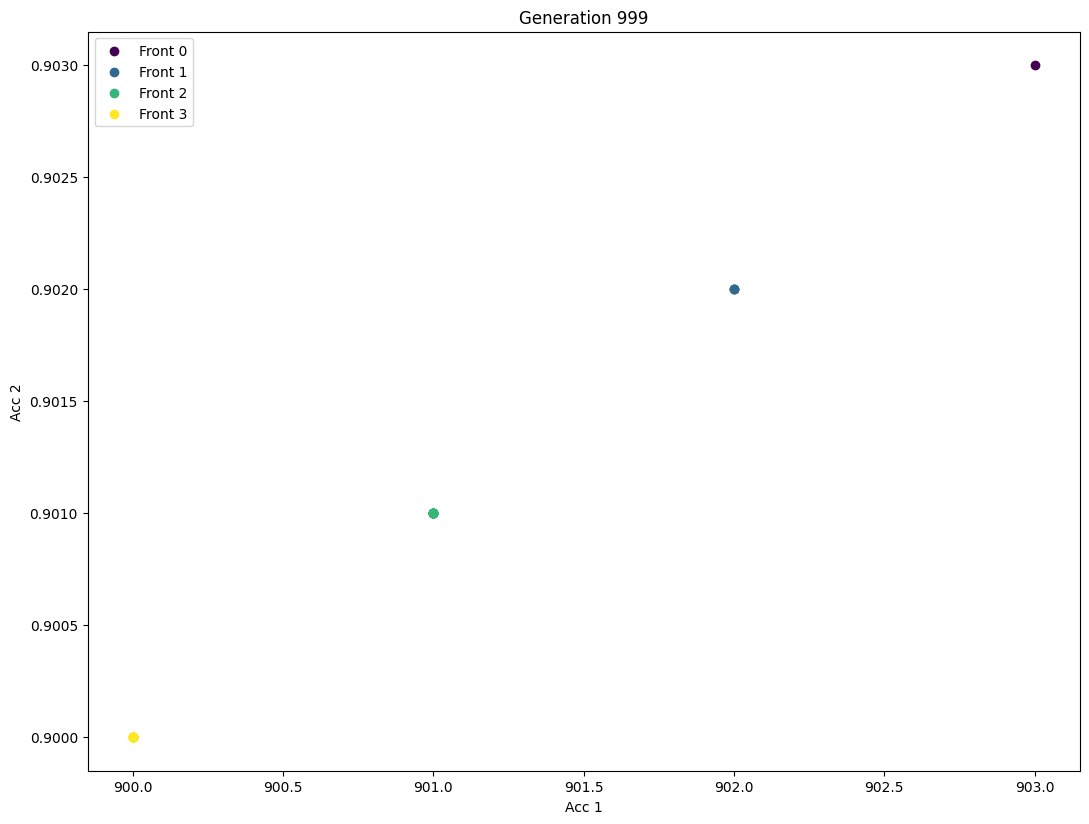

In [14]:
# Step 2: 动画绘图函数
fig = plt.figure(figsize=(12.8, 9.6))
ax = fig.add_subplot(111)
# 动画中的数据
pareto_fronts_history = []
def update(frame):
    ax.clear()
    colors = plt.cm.viridis(np.linspace(0, 1, len(pareto_fronts_history[frame])))
    for i, front in enumerate(pareto_fronts_history[frame]):
        front_points = np.array([ind.fitness.values for ind in front])
        ax.scatter(front_points[:, 0], front_points[:, 1], color=colors[i], label=f"Front {i}")
    ax.set_title(f"Generation {frame}")
    ax.set_xlabel("Acc 1")
    ax.set_ylabel("Acc 2")
    ax.legend()


def main(seed=None):
    random.seed(seed)

    NGEN = 50000  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.25  # 突变因子/突变率

    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "fronts", "fronts_0_size", "Acc1", "Acc2", "Acc3", "recall_per_class", "Gmean", "mAUC"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    ####################################计算初始种群的适应度###########################
    for i in range(len(pop)):
        pop[i].fitness.values = toolbox.evaluate(pop[i])
    #################################计算PFC并进行非支配排序#########################################
    # 计算PFC并进行非支配排序 PFC代替拥挤距离
    pop = toolbox.select(pop, len(pop))
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        # 选择
        offspring = tools.selTournamentDCD(pop, POPSIZE)
        offspring = [toolbox.clone(ind) for ind in offspring]
        # 交叉
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
            # 突变
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        # 计算新的种群适应度 
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])
        # 种群的合并
        pop = pop + offspring
        ###############################################得到pareto_fronts############################################
        pop= toolbox.select(pop, POPSIZE)
        pareto_fronts=tools.sortNondominated(pop, POPSIZE)
        record = stats.compile(pop)
        # 保存第一个等级里的mlp模型进行集成
        logbook.record(gen=gen, fronts=len(pareto_fronts), fronts_0_size=len(pareto_fronts[0]),**record)
        print(logbook.stream)
        # 清除并绘制当前一代的 Pareto-front
        if gen % 50 == 0:
            pareto_fronts_history.append(pareto_fronts)
    # 使用 FuncAnimation 生成动画
    savepath = "C:/Users/zsc/Desktop/"
    writer = PillowWriter(fps=10)  # 设置帧率
    anim = FuncAnimation(fig, update, frames=len(pareto_fronts_history), interval=200)
    anim.save(savepath + "datasetname" + "_pareto_front.gif", writer=writer)
    plt.show()
    return pop, stats


if __name__ == "__main__":
    pop, stats = main()